In [1]:
library("checkpoint")
checkpoint("2019-04-23")
library(dplyr)
library(tidyr)
library(stringr)
#install.packages('widyr',lib=.libPaths()[3])
library(widyr)
#install.packages('readr',lib=.libPaths()[3])
library(readr)
#install.packages('igraph',lib=.libPaths()[3])
library(igraph)
block = read_csv("Open.csv", col_names = TRUE, quote = "\"")
block2 = read_csv("Reproduce.csv", col_names = TRUE, quote = "\"")


checkpoint: Part of the Reproducible R Toolkit from Microsoft
https://mran.microsoft.com/documents/rro/reproducibility/
Scanning for packages used in this project
- Discovered 15 packages
All detected packages already installed
checkpoint process complete
---

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following object is masked from ‘package:tidyr’:

    crossing

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Parsed with column specification:
cols(
  .default = col_character(),
  PaperId = col_double(),
  Rank = col_double(),
  JournalId = col_double(),
  ConferenceInstanceId = col_double(),
  Year = col_double(),

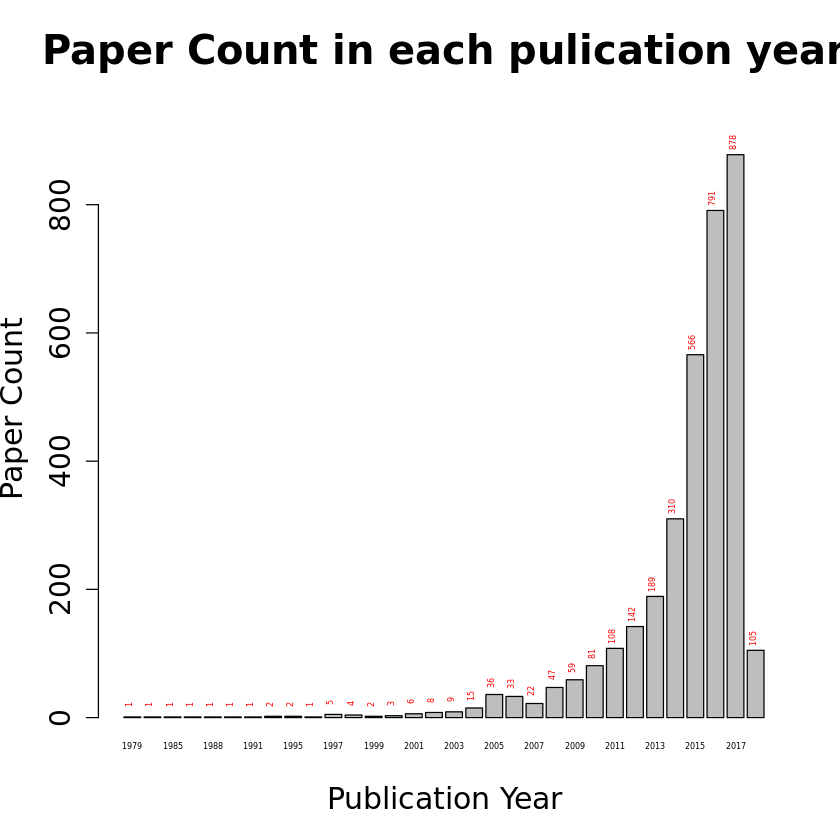

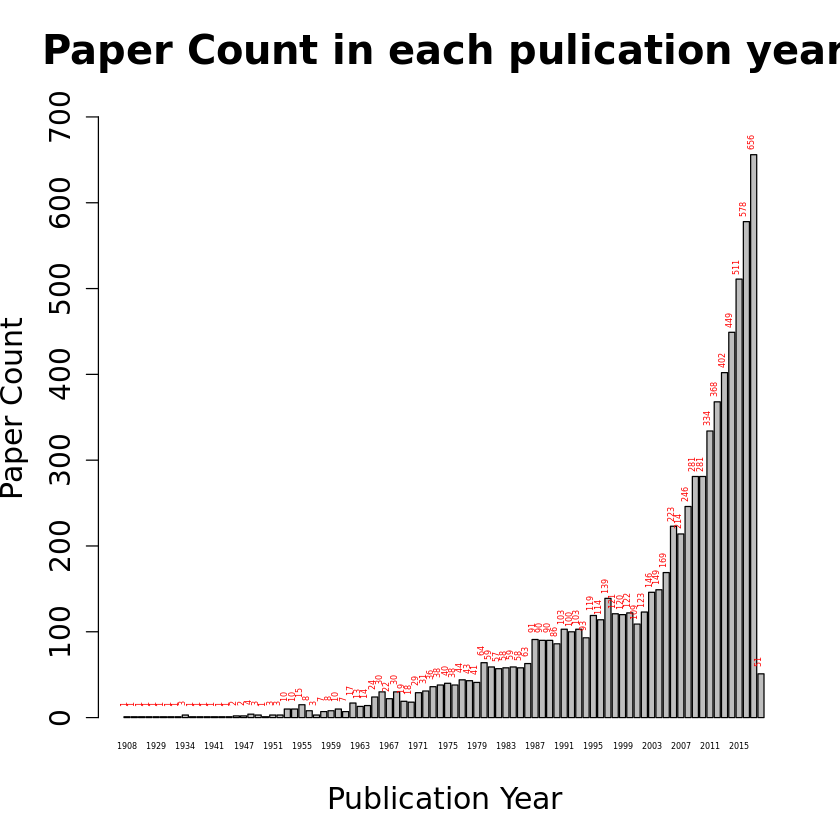

In [2]:
myvars <- c("Year")
data <- block[myvars]
counts <- table(data)
ylim <- c(0, 1.1*max(counts))
xx <- barplot(counts, xaxt = 'n', width = 0.85, ylim = ylim,
              cex.lab=1.5, cex.axis=1.4, cex.main=2, cex.sub=2,
              main = "Paper Count in each pulication year",
              xlab = "Publication Year",
              ylab = "Paper Count")
text(x = xx, y = counts, label = counts, srt=90,  pos = 3, cex = 0.4, col = "red")
axis(1, at=xx, labels=attributes(counts)$dimnames$data, tick=FALSE, line=-0.5, cex.axis=0.4)

myvars <- c("Year")
data <- block2[myvars]
counts <- table(data)
ylim <- c(0, 1.1*max(counts))
xx <- barplot(counts, xaxt = 'n', width = 0.85, ylim = ylim,
              cex.lab=1.5, cex.axis=1.4, cex.main=2, cex.sub=2,
              main = "Paper Count in each pulication year",
              xlab = "Publication Year",
              ylab = "Paper Count")
text(x = xx, y = counts, label = counts, srt=90,  pos = 3, cex = 0.4, col = "red")
axis(1, at=xx, labels=attributes(counts)$dimnames$data, tick=FALSE, line=-0.5, cex.axis=0.4)

### We start data cleaning by checking the publication years. Our original choice of 2010-2017 remains fundamentally sound here. Next, check document types.

In [3]:
myvars <- c("AuthorNames", "FoSNames", "Year", "DocType", "DisplayName" , "Doi", "OriginalTitle", "URLs")
data <- block[myvars]
data <- data[data$Year >=2010 & data$Year <=2017,]
data <- data[is.na(data$DocType),]
#write_csv(data, "noTypeOpen.csv")
data <- block2[myvars]
data <- data[data$Year >=2010 & data$Year <=2017,]
data <- data[is.na(data$DocType),]
#write_csv(data, "noTypeRep.csv")

data <- block[myvars]
data <- data[data$Year >=2010 & data$Year <=2017,]
data <- data[!is.na(data$DocType),]
data2 <- data[is.na(data$URLs),]
#write_csv(data2, "noURLOpen.csv")
#write_csv(data, "typeOpen.csv")
data <- block2[myvars]
data <- data[data$Year >=2010 & data$Year <=2017,]
data <- data[!is.na(data$DocType),]
data2 <- data[is.na(data$URLs),]
#write_csv(data2, "noURLRep.csv")
#write_csv(data, "typeRep.csv")

### The new data now contains new document types includin books and book chapters, together with Patent document type, they are all excluded. The data quality of the remaining document types (jouranl and conference) is much higher compared with original crawled data, manual cleaning is no longer necessary (check tables in depreciated folder). DOI coverage is only missing 7 in reproducbility and 1 in open science, which is good news for matching WoS records.

In [4]:
myvars <- c("PaperId", "AuthorIds", "AuthorIdsOrder", "Year", "DocType", "OriginalTitle", "EstimatedCitation")
data <- block[myvars]
data <- data[data$Year >=2010 & data$Year <=2017,]
data <- data[!is.na(data$DocType),]
data <- data[data$DocType!="Book",]
data <- data[data$DocType!="BookChapter",]
data <- data[data$DocType!="Patent",]
data$authorCount <- str_count(data$AuthorIdsOrder, '; ')+1
data <- data[data$authorCount>1,]

data <- arrange(data, tolower(as.character(OriginalTitle)), EstimatedCitation, Year, DocType) #put most cited, last the version of each paper that is published later, have more authors and are journal articles (will retain these)
titles <- tolower(as.character(data$OriginalTitle))
duplicated1 <- which(duplicated(titles)) #
duplicated2 <- which(duplicated(titles, fromLast=TRUE)) #remove these (keep the last appearing one of each set of duplicates)
duplicated_all <- sort(unique(c(duplicated1,duplicated2)))
duplicated_keep <- setdiff(duplicated_all, duplicated2)
data_duplicated <- data[duplicated_all,]
data_duplicated_keep <- data[duplicated_keep,]
#write.csv(data[duplicated2,], 'duplicated_remove0.csv', row.names=FALSE)
data <- data[-(duplicated2),]

AuthorTable <- data %>% separate(AuthorIdsOrder, into = sprintf('%s.%s', rep('Author',100), rep(1:100)), sep = "; ") #max author has exceeded 90
AuthorTable <- AuthorTable %>% gather(authorOrder, AuthorIdsOrder, into = sprintf('%s.%s', rep('Author',100), rep(1:100)))
AuthorTable <- AuthorTable[!is.na(AuthorTable$AuthorIdsOrder), ]
#AuthorTable

Warning message:
“Expected 100 pieces. Missing pieces filled with `NA` in 624 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

In [5]:
PaperCollab <- pairwise_count(AuthorTable, PaperId, AuthorIdsOrder, sort = TRUE)
openG <- graph_from_data_frame(d = PaperCollab, directed=FALSE, vertices=data)
write_graph(openG, "openRaw.graphml", format="graphml")
n1=vcount(openG)
m1=ecount(openG)/2
n1
m1

[1] 624

[1] 294

In [6]:
myvars <- c("PaperId", "AuthorIds", "AuthorIdsOrder", "Year", "DocType", "OriginalTitle", "EstimatedCitation")
data2 <- block2[myvars]
data2 <- data2[data2$Year >=2010 & data2$Year <=2017,]
data2 <- data2[!is.na(data2$DocType),]
data2 <- data2[data2$DocType!="Book",]
data2 <- data2[data2$DocType!="BookChapter",]
data2 <- data2[data2$DocType!="Patent",]
data2$authorCount <- str_count(data2$AuthorIdsOrder, '; ')+1
data2 <- data2[data2$authorCount>1,]

data2 <- arrange(data2, tolower(as.character(OriginalTitle)), EstimatedCitation, Year, DocType) #put most cited, last the version of each paper that is published later, have more authors and are journal articles (will retain these)
titles <- tolower(as.character(data2$OriginalTitle))
duplicated1 <- which(duplicated(titles)) #
duplicated2 <- which(duplicated(titles, fromLast=TRUE)) #remove these (keep the last appearing one of each set of duplicates)
duplicated_all <- sort(unique(c(duplicated1,duplicated2)))
duplicated_keep <- setdiff(duplicated_all, duplicated2)
data2_duplicated <- data2[duplicated_all,]
data2_duplicated_keep <- data2[duplicated_keep,]
#write.csv(data2[duplicated2,], 'duplicated_remove1.csv', row.names=FALSE)
data2 <- data2[-(duplicated2),]

AuthorTable2 <- data2 %>% separate(AuthorIdsOrder, into = sprintf('%s.%s', rep('Author',100), rep(1:100)), sep = "; ") #max author has exceeded 90
AuthorTable2 <- AuthorTable2 %>% gather(authorOrder, AuthorIdsOrder, into = sprintf('%s.%s', rep('Author',100), rep(1:100)))
AuthorTable2 <- AuthorTable2[!is.na(AuthorTable2$AuthorIdsOrder), ]
#AuthorTable2

Warning message:
“Expected 100 pieces. Missing pieces filled with `NA` in 1707 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

In [7]:
PaperCollab2 <- pairwise_count(AuthorTable2, PaperId, AuthorIdsOrder, sort = TRUE)
repG <- graph_from_data_frame(d = PaperCollab2, directed=FALSE, vertices=data2)
write_graph(repG, "reproduceRaw.graphml", "graphml")
n2=vcount(repG)
m2=ecount(repG)/2
n2
m2

[1] 1707

[1] 647

### After creating the networks, we proceed to conduct network analysis

In [8]:
nrow(data)+nrow(data2)

[1] 2331

In [9]:
AuthorTable %>% summarize(n = n_distinct(AuthorIdsOrder))
AuthorTable2 %>% summarize(n = n_distinct(AuthorIdsOrder))
AuthorTable0 <- dplyr::bind_rows(list(OpenScience=AuthorTable, Reproducibility=AuthorTable2), .id = 'Tag')
AuthorTable0 %>% summarize(n = n_distinct(AuthorIdsOrder))

ERROR while rich displaying an object: Error: 'vec_is' is not an exported object from 'namespace:vctrs'

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_html.data.frame(

  n   
1 2949

ERROR while rich displaying an object: Error: 'vec_is' is not an exported object from 'namespace:vctrs'

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_html.data.frame(

  n   
1 8492

ERROR while rich displaying an object: Error: 'vec_is' is not an exported object from 'namespace:vctrs'

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_html.data.frame(

  n    
1 11393

In [10]:
nrow(block)+nrow(block2)
nrow(block)
nrow(block2)
nrow(block01)
nrow(block02)

[1] 11270

[1] 3431

[1] 7839

ERROR: Error in nrow(block01): object 'block01' not found


### Network density measures and Fisher's Exact Test

In [11]:
2*m1/n1/(n1-1)
2*m2/n2/(n2-1)

[1] 0.001512532

[1] 0.0004443465

In [12]:
table <- cbind(c(m1,m2),c(n1*(n1-1)/2-m1,n2*(n2-1)/2-m2))
fisher.test(table, alternative="greater")

table <- rbind(c(m1,m2),c(n1*(n1-1)/2-m1,n2*(n2-1)/2-m2))
fisher.test(table, alternative="greater")


	Fisher's Exact Test for Count Data

data:  table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 3.025957      Inf
sample estimates:
odds ratio 
  3.407276 



	Fisher's Exact Test for Count Data

data:  table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 3.025957      Inf
sample estimates:
odds ratio 
  3.407276 


In [13]:
n1/452
n2/1364

[1] 1.380531

[1] 1.251466

### Network analysis ends with average component sizes (Other analysis is done in Gephi). Finally, we merge the two data sets into "newdataCombined.csv" for downstream gender detection. Papers of all years are kepted for plotting purposes.

In [6]:
myvars <- c("PaperId", "AuthorIdsOrder", "AuthorNamesOrder", "FoSNames", "Year", "DocType", "DisplayName", "Publisher", "Doi", 
            "OriginalTitle", "EstimatedCitation", "URLs", "IndexedAbstract")
data01 <- block[myvars]
data02 <- block2[myvars]
data0 <- dplyr::bind_rows(list(OpenScience=data01, Reproducibility=data02), .id = 'Tag')
#data0 <- data0[data0$Year >=2010 & data0$Year <=2017,]
data0 <- data0[!is.na(data0$DocType),]
data0 <- data0[data0$DocType!="Book",]
data0 <- data0[data0$DocType!="BookChapter",]
data0 <- data0[data0$DocType!="Patent",]

data0 <- arrange(data0, tolower(as.character(OriginalTitle)), EstimatedCitation, Year, DocType) #put most cited, last the version of each paper that is published later, have more authors and are journal articles (will retain these)
titles <- tolower(as.character(data0$OriginalTitle))
duplicated1 <- which(duplicated(titles)) #
duplicated2 <- which(duplicated(titles, fromLast=TRUE)) #remove these (keep the last appearing one of each set of duplicates)
duplicated_all <- sort(unique(c(duplicated1,duplicated2)))
duplicated_keep <- setdiff(duplicated_all, duplicated2)
data0_duplicated <- data0[duplicated_all,]
data0_duplicated_keep <- data0[duplicated_keep,]
write.csv(data0[duplicated2,], 'duplicated_remove.csv', row.names=FALSE)
data0 <- data0[-(duplicated2),]

#data0$ID <- seq.int(nrow(data0))
data0 <- rename(data0, "Journal" = "DisplayName", "Title" = "OriginalTitle")
write_csv(data0, "newdataCombined.csv")
#sum(is.na(data0$IndexedAbstract)&(data0$Tag == "OpenScience"))
#sum(is.na(data0$IndexedAbstract)&(data0$Tag == "Reproducibility"))

[1] 233

[1] 1704

In [52]:
233/n1
1704/n2

[1] 0.2338252

[1] 0.3987403

In [15]:
data9 = read_csv("output/OpenSci3Discipline.csv", col_names = TRUE)
#data9$disc_name
sum((data9$DocType == "Journal")&(data9$Tag == "OpenScience"))
sum((data9$DocType == "Journal")&(data9$Tag == "Reproducibility"))
sum(!is.na(data9$disc_name)&(data9$Tag == "OpenScience")&(data9$DocType == "Conference"))
sum(!is.na(data9$disc_name)&(data9$Tag == "Reproducibility")&(data9$DocType == "Conference"))
sum(!is.na(data9$disc_name)&(data9$Tag == "OpenScience")&(data9$DocType == "Journal"))
sum(!is.na(data9$disc_name)&(data9$Tag == "Reproducibility")&(data9$DocType == "Journal"))

Parsed with column specification:
cols(
  .default = col_character(),
  PaperId = col_double(),
  authorCount = col_double(),
  unknownCount = col_double(),
  femaleCount = col_double(),
  femaleProp = col_double(),
  `1st` = col_double(),
  `2nd` = col_double(),
  `3rd` = col_double(),
  `4th` = col_double(),
  `5th` = col_double(),
  last = col_double(),
  Year = col_double(),
  EstimatedCitation = col_double()
)
See spec(...) for full column specifications.


[1] 791

[1] 1894

[1] 0

[1] 5

[1] 245

[1] 1444

In [17]:
dataO <- data9[data9$Tag == "OpenScience",]
dataR <- data9[data9$Tag == "Reproducibility",]

nrow(filter(dataO, grepl("workflow", FoSNames, fixed = TRUE)))
nrow(filter(dataR, grepl("workflow", FoSNames, fixed = TRUE)))

nrow(filter(dataO, grepl("repeatability", FoSNames, fixed = TRUE)))
nrow(filter(dataR, grepl("repeatability", FoSNames, fixed = TRUE)))

nrow(filter(dataO, grepl("data sharing", FoSNames, fixed = TRUE)))
nrow(filter(dataR, grepl("data sharing", FoSNames, fixed = TRUE)))

nrow(filter(dataO, grepl("open data", FoSNames, fixed = TRUE)))
nrow(filter(dataR, grepl("open data", FoSNames, fixed = TRUE)))

nrow(filter(dataO, grepl("software", FoSNames, fixed = TRUE)))
nrow(filter(dataR, grepl("software", FoSNames, fixed = TRUE)))

[1] 39

[1] 33

[1] 0

[1] 260

[1] 76

[1] 11

[1] 267

[1] 2

[1] 103

[1] 79

### Counting papers for supplimentary information

In [4]:
block01 = read_tsv("input/Open-old.csv", col_names = TRUE, quote = "\"")
block02 = read_tsv("input/Reproduce-old.csv", col_names = TRUE, quote = "\"")

myvars <- c("PaperId", "AuthorIds", "AuthorNames", "FoSNames", "Year", "DocType", "DisplayName", "Publisher", "Doi", 
            "OriginalTitle", "EstimatedCitation", "IndexedAbstract")
data01 <- block01[myvars]
data02 <- block02[myvars]
AuthorTable <- data01 %>% separate(AuthorIds, into = sprintf('%s.%s', rep('Author',100), rep(1:100)), sep = "; ") #max author has exceeded 90
AuthorTable <- AuthorTable %>% gather(authorOrder, AuthorIds, into = sprintf('%s.%s', rep('Author',100), rep(1:100)))
AuthorTable <- AuthorTable[!is.na(AuthorTable$AuthorIds), ]

AuthorTable2 <- data02 %>% separate(AuthorIds, into = sprintf('%s.%s', rep('Author',100), rep(1:100)), sep = "; ") #max author has exceeded 90
AuthorTable2 <- AuthorTable2 %>% gather(authorOrder, AuthorIds, into = sprintf('%s.%s', rep('Author',100), rep(1:100)))
AuthorTable2 <- AuthorTable2[!is.na(AuthorTable2$AuthorIds), ]

AuthorTable %>% summarize(n = n_distinct(AuthorIds))
AuthorTable2 %>% summarize(n = n_distinct(AuthorIds))
AuthorTable0 <- dplyr::bind_rows(list(OpenScience=AuthorTable, Reproducibility=AuthorTable2), .id = 'Tag')
AuthorTable0 %>% summarize(n = n_distinct(AuthorIds))
length(intersect(AuthorTable$AuthorIds, AuthorTable2$AuthorIds))

Parsed with column specification:
cols(
  .default = col_character(),
  PaperId = col_double(),
  Rank = col_double(),
  JournalId = col_double(),
  ConferenceInstanceId = col_double(),
  Year = col_double(),
  Date = col_datetime(format = ""),
  ReferenceCount = col_double(),
  CitationCount = col_double(),
  EstimatedCitation = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  PaperId = col_double(),
  Rank = col_double(),
  JournalId = col_double(),
  ConferenceInstanceId = col_double(),
  Year = col_double(),
  Date = col_datetime(format = ""),
  ReferenceCount = col_double(),
  CitationCount = col_double(),
  EstimatedCitation = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Expected 100 pieces. Additional pieces discarded in 3 rows [1362, 2545, 2792].”Warning message:
“Expected 100 pieces. Missing pieces filled with `NA` in 3496 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

  n   
1 9308

ERROR while rich displaying an object: Error: 'vec_is' is not an exported object from 'namespace:vctrs'

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_html.data.frame(

  n    
1 27445

ERROR while rich displaying an object: Error: 'vec_is' is not an exported object from 'namespace:vctrs'

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_html.data.frame(

  n    
1 36296

[1] 457

In [42]:
nrow(block01)-68
nrow(block02)-68
nrow(block02)+nrow(block01)-68-68

[1] 3431

[1] 7839

[1] 11270